In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, BatchNormalization
from keras.utils import to_categorical
import tensorflow as tf

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")

# --- Load and filter labels for MI only ---
labels_df = pd.read_csv(labels_path)
mi_labels = ['Left', 'Right']  # change as needed
mi_labels_df = labels_df[labels_df['label'].isin(mi_labels)]

X = []
y = []
missing_files = []

for i, row in mi_labels_df.iterrows():
    subject = row['subject_id']
    session = row['trial_session']
    trial_num = int(row['trial'])  # 1-based
    label = row['label']

    npy_path = os.path.join(dl_ready_dir, f"{subject}_{session}_EEGdata_preprocessed_DLready.npy")
    if not os.path.exists(npy_path):
        missing_files.append(npy_path)
        continue

    epochs = np.load(npy_path)  # shape: (n_trials, n_channels, n_samples)

    if trial_num - 1 >= epochs.shape[0]:
        print(f"Warning: trial number {trial_num} out of range in file {npy_path}")
        continue

    X.append(epochs[trial_num - 1])  # Select the trial data
    y.append(label)

X = np.stack(X)  # shape: (num_trials, n_channels, n_samples)

# Encode labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# Transpose X to (samples, timesteps, channels) for Conv1D + LSTM input
X = np.transpose(X, (0, 2, 1))

# One-hot encode labels
num_classes = len(np.unique(y_enc))
y_cat = to_categorical(y_enc, num_classes=num_classes)

# Split into train and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)

# Build the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    ]
)

if missing_files:
    print(f"Warning: {len(missing_files)} files were missing, e.g. {missing_files[:3]}")

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2244, 64)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2244, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1122, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1122, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1118, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1118, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 559, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 559, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 557, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 557, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 278, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 278, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,354 (1.33 MB)

 Trainable params: 347,458 (1.33 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 592ms/step - accuracy: 0.5111 - loss: 0.7178 - val_accuracy: 0.4619 - val_loss: 0.6993
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 689ms/step - accuracy: 0.4959 - loss: 0.7125 - val_accuracy: 0.4992 - val_loss: 0.6977
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 79s 650ms/step - accuracy: 0.4959 - loss: 0.7044 - val_accuracy: 0.4992 - val_loss: 0.6963
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 53s 655ms/step - accuracy: 0.5002 - loss: 0.6981 - val_accuracy: 0.5039 - val_loss: 0.6948
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 620ms/step - accuracy: 0.5064 - loss: 0.6991 - val_accuracy: 0.4743 - val_loss: 0.6966
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 577ms/step - accuracy: 0.5259 - loss: 0.6946 - val_accuracy: 0.4728 - val_loss: 0.6957
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 49s 609ms/step - accuracy: 0.5084 - loss: 0.6957 - val_accuracy: 0.5023 - val_loss: 0.6962
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 50s 612ms/step - accuracy: 0.4990 - loss: 0.6960 - val_accu

In [4]:
import os
import pickle

# --- Save MI model and label encoder ---
mi_model_path = os.path.join(base_dir, "mi_model.keras")
mi_encoder_path = os.path.join(base_dir, "mi_label_encoder.pkl")

# Save the trained model (recommended Keras format)
model.save(mi_model_path)
print(f"MI model saved to: {mi_model_path}")

# Save the LabelEncoder object (for later decoding)
with open(mi_encoder_path, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"MI label encoder saved to: {mi_encoder_path}")


MI model saved to: C:\Users\zezom\PycharmProjects\HorusEye\mi_model.keras
MI label encoder saved to: C:\Users\zezom\PycharmProjects\HorusEye\mi_label_encoder.pkl


# SVM

[INFO] Total MI trials found: 3584
[SKIP] Trial 10 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S9_8_EEGdata_preprocessed_C3_mu.csv has insufficient samples
[SKIP] Trial 10 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S9_8_EEGdata_preprocessed_C3_beta.csv has insufficient samples
[SKIP] Trial 10 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S9_8_EEGdata_preprocessed_C4_mu.csv has insufficient samples
[SKIP] Trial 10 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S9_8_EEGdata_preprocessed_C4_beta.csv has insufficient samples
[SKIP] Trial 8 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S28_4_EEGdata_preprocessed_C3_mu.csv has insufficient samples
[SKIP] Trial 8 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S28_4_EEGdata_preprocessed_C3_beta.csv has insufficient samples
[SKIP] Trial 8 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI\S28_4_EEGdata_preprocessed_C4_mu.csv has insufficient s

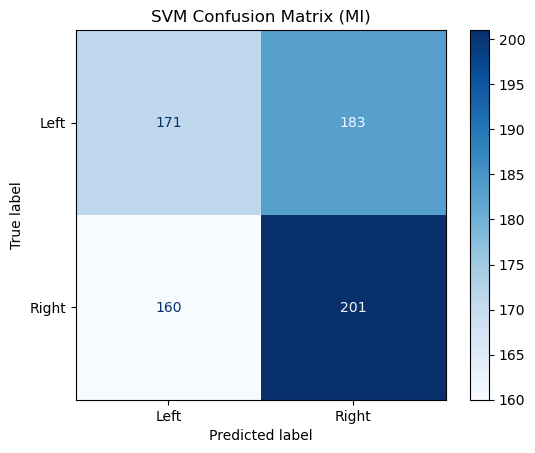

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
csv_data_dir = os.path.join(base_dir, "Data", "Processed", "MI")
labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
mi_labels = ['Left', 'Right']
channels = ['C3', 'C4']
bands = ['mu', 'beta']

# --- Load Labels ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
mi_df = labels_df[labels_df['label'].isin(mi_labels)]
print(f"[INFO] Total MI trials found: {len(mi_df)}")

# --- Load MI Trials ---
X = []
y = []

for i, row in mi_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])
    label = row['label'].strip()

    trial_features = []

    for ch in channels:
        for band in bands:
            file_name = f"{subject}_{session}_EEGdata_preprocessed_{ch}_{band}.csv"
            csv_path = os.path.join(csv_data_dir, file_name)
            if not os.path.exists(csv_path):
                print(f"[MISSING] {csv_path}")
                continue
            try:
                df = pd.read_csv(csv_path)
                start_idx = (trial_num - 1) * samples_per_trial
                end_idx = trial_num * samples_per_trial
                trial_data = df.iloc[start_idx:end_idx].values

                if trial_data.shape[0] != samples_per_trial:
                    print(f"[SKIP] Trial {trial_num} in {csv_path} has insufficient samples")
                    continue

                trial_features.extend(trial_data.flatten())
            except Exception as e:
                print(f"[ERROR] {csv_path}, Trial {trial_num}: {e}")
                continue

    if len(trial_features) > 0:
        X.append(trial_features)
        y.append(label)

# --- Final Preprocessing ---
if len(X) == 0:
    raise RuntimeError("No valid data loaded!")

X = np.array(X)
y = np.array(y)
print(f"[INFO] Final dataset shape: {X.shape}, Labels: {np.unique(y)}")

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- Train SVM ---
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # Tuned hyperparameters
svm_model.fit(X_train, y_train)

# --- Evaluate ---
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"[RESULT] SVM Validation Accuracy (MI): {acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix (MI)")
plt.show()


In [2]:
import os
import pickle

# --- Save Paths ---
svm_model_path = os.path.join(base_dir, "svm_mi_model.pkl")
svm_scaler_path = os.path.join(base_dir, "svm_scaler.pkl")
svm_encoder_path = os.path.join(base_dir, "svm_label_encoder.pkl")

# --- Save the SVM model ---
with open(svm_model_path, "wb") as f_model:
    pickle.dump(svm_model, f_model)
print(f"SVM model saved to: {svm_model_path}")

# --- Save the scaler ---
with open(svm_scaler_path, "wb") as f_scaler:
    pickle.dump(scaler, f_scaler)
print(f"SVM scaler saved to: {svm_scaler_path}")

# --- Save the LabelEncoder ---
with open(svm_encoder_path, "wb") as f_enc:
    pickle.dump(label_encoder, f_enc)
print(f"SVM label encoder saved to: {svm_encoder_path}")


SVM model saved to: C:\Users\zezom\PycharmProjects\HorusEye\svm_mi_model.pkl
SVM scaler saved to: C:\Users\zezom\PycharmProjects\HorusEye\svm_scaler.pkl
SVM label encoder saved to: C:\Users\zezom\PycharmProjects\HorusEye\svm_label_encoder.pkl


# Deep Learning

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
csv_data_dir = os.path.join(base_dir, "Data", "Processed", "MI")
labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
channels = ['C3', 'C4']
bands = ['mu', 'beta']
mi_labels = ['Left', 'Right']

# --- Load Labels ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
mi_df = labels_df[labels_df['label'].isin(mi_labels)]

# --- Load Data ---
X = []
y = []

for i, row in mi_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])
    label = row['label'].strip()
    trial_channels = []
    for ch in channels:
        for band in bands:
            file_name = f"{subject}_{session}_EEGdata_preprocessed_{ch}_{band}.csv"
            csv_path = os.path.join(csv_data_dir, file_name)
            if not os.path.exists(csv_path):
                continue
            df = pd.read_csv(csv_path)
            start_idx = (trial_num - 1) * samples_per_trial
            end_idx = trial_num * samples_per_trial
            trial_data = df.iloc[start_idx:end_idx].values
            if trial_data.shape[0] != samples_per_trial:
                continue
            trial_channels.append(trial_data.flatten())
    if len(trial_channels) == len(channels) * len(bands):
        # Stack as (num_channels, num_samples)
        stacked = np.stack(trial_channels, axis=0)
        X.append(stacked)
        y.append(label)

X = np.array(X)  # Shape: (n_trials, n_channels*bands, n_samples)
y = np.array(y)
print("[INFO] X.shape:", X.shape)  # Expect (n_trials, 4, 1750)
print("[INFO] y.shape:", y.shape)

# --- Preprocessing ---
# Normalize per trial
X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)


[INFO] X.shape: (3571, 4, 1750)
[INFO] y.shape: (3571,)


In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation, Dropout, MaxPooling1D, Flatten, Dense, InputLayer

n_channels = X_train.shape[1]
input_length = X_train.shape[2]
n_classes = y_cat.shape[1]

model = Sequential([
    InputLayer(input_shape=(n_channels, input_length)),
    # 1st Conv block
    Conv1D(32, kernel_size=15, padding='same', data_format='channels_first'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2, data_format='channels_first'),
    Dropout(0.3),

    # 2nd Conv block
    Conv1D(64, kernel_size=7, padding='same', data_format='channels_first'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2, data_format='channels_first'),
    Dropout(0.3),

    # Output block
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 1750)       │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 1750)       │         7,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 1750)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 875)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 875)        │         3,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,790,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,998 (6.93 MB)

 Trainable params: 1,811,748 (6.91 MB)

 Non-trainable params: 5,250 (20.51 KB)

In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)


Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.4937 - loss: 1.3953 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.4895 - loss: 0.6943 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accu

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5063 - loss: 0.6931
[RESULT] Deep Learning Validation Accuracy (MI): 0.5063
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


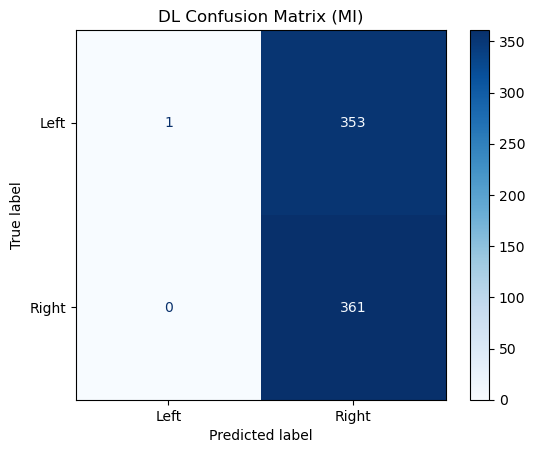

In [6]:
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"[RESULT] Deep Learning Validation Accuracy (MI): {test_acc:.4f}")

# Confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("DL Confusion Matrix (MI)")
plt.show()


In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# Save using the new recommended Keras format
model.save('mi_cnn_model.keras')
print("Model saved as mi_cnn_model.keras")


Epoch 1/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 2/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 3/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5056 - loss: 0.7088 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 4/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.5060 - loss: 0.6931 - val_accuracy: 0.5063 - val_loss: 0.6930
Epoch 5/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.5098 - loss: 0.6927 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 6/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5063 - loss: 0.6930 - val_accuracy: 0.5049 - val_loss: 0.6925
Epoch 7/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5154 - loss: 0.6947 - val_accuracy: 0.5329 - val_loss: 0.6929
Epoch 8/40
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.5109 - loss: 0.6923 - val_accu

# Model wiht Balance

[INFO] Train set class counts: [1412 1444]
[INFO] Test set class counts: [354 361]
[INFO] Label encoder mapping: ['Left' 'Right']


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 32, 1750)       │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 1750)       │         7,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 1750)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 875)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 875)        │         3,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 27968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,790,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,518 (6.93 MB)

 Trainable params: 1,811,268 (6.91 MB)

 Non-trainable params: 5,250 (20.51 KB)

[INFO] Class weights: {0: 1.0113314447592068, 1: 0.9889196675900277}
Epoch 1/60
90/90 - 15s - 164ms/step - accuracy: 0.4793 - loss: 0.7736 - val_accuracy: 0.5007 - val_loss: 0.6935
Epoch 2/60
90/90 - 13s - 141ms/step - accuracy: 0.5077 - loss: 0.6929 - val_accuracy: 0.5035 - val_loss: 0.6932
Epoch 3/60
90/90 - 13s - 144ms/step - accuracy: 0.5091 - loss: 0.6903 - val_accuracy: 0.4881 - val_loss: 0.6924
Epoch 4/60
90/90 - 12s - 136ms/step - accuracy: 0.5074 - loss: 0.6953 - val_accuracy: 0.5147 - val_loss: 0.6937
Epoch 5/60
90/90 - 12s - 131ms/step - accuracy: 0.5245 - loss: 0.6901 - val_accuracy: 0.5119 - val_loss: 0.6946
Epoch 6/60
90/90 - 12s - 133ms/step - accuracy: 0.5207 - loss: 0.6876 - val_accuracy: 0.5091 - val_loss: 0.7043
Epoch 7/60
90/90 - 12s - 135ms/step - accuracy: 0.5483 - loss: 0.6839 - val_accuracy: 0.5147 - val_loss: 0.6920
Epoch 8/60
90/90 - 13s - 141ms/step - accuracy: 0.5340 - loss: 0.6850 - val_accuracy: 0.5175 - val_loss: 0.6921
Epoch 9/60
90/90 - 18s - 194ms/step

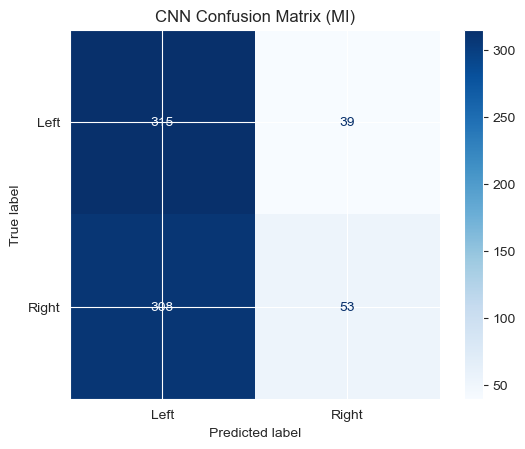

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical

# ----------------- Load & Prepare Data -----------------
# Simulated example: replace with real loading
# X.shape = (n_trials, n_channels=3, n_samples=1750)
# y.shape = (n_trials,) = class labels ('Left', 'Right')
data_path = r"C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\MI"
csv_path = r"C:\Users\zezom\PycharmProjects\HorusEye\train.csv"

# Example EEG loading (adjust as needed)
channels = ['C3_ref', 'CZ_ref', 'C4_ref']
samples_per_trial = 1750

labels_df = pd.read_csv(csv_path).dropna()
mi_labels = ['Left', 'Right']
labels_df = labels_df[labels_df['label'].isin(mi_labels)]

X, y = [], []
for _, row in labels_df.iterrows():
    file = f"{row['subject_id']}_{row['trial_session']}_EEGdata_preprocessed.csv"
    path = f"{data_path}/{file}"
    if not tf.io.gfile.exists(path):
        continue
    df = pd.read_csv(path)
    start = (row['trial'] - 1) * samples_per_trial
    end = row['trial'] * samples_per_trial
    trial = df[channels].iloc[start:end].values.T
    if trial.shape[1] == samples_per_trial:
        X.append(trial)
        y.append(row['label'])

X = np.array(X)
X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# ----------------- Check Data Balance -----------------
y_train_lbl = np.argmax(y_train, axis=1)
y_test_lbl = np.argmax(y_test, axis=1)
print("[INFO] Train set class counts:", np.bincount(y_train_lbl))
print("[INFO] Test set class counts:", np.bincount(y_test_lbl))
print("[INFO] Label encoder mapping:", le.classes_)

# ----------------- Build CNN Model -----------------
n_channels = X_train.shape[1]
input_length = X_train.shape[2]
n_classes = y_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_channels, input_length)),
    tf.keras.layers.Conv1D(32, kernel_size=15, padding='same', data_format='channels_first'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, data_format='channels_first'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv1D(64, kernel_size=7, padding='same', data_format='channels_first'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, data_format='channels_first'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ----------------- Handle Class Imbalance -----------------
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_lbl),
    y=y_train_lbl
)
class_weights = dict(zip(np.unique(y_train_lbl), cw))
print("[INFO] Class weights:", class_weights)

# ----------------- Train Model -----------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_mi_cnn_model.keras", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# ----------------- Save Final Model -----------------
model.save('mi_cnn_model.keras')
print("Model saved as mi_cnn_model.keras")

# ----------------- Evaluate -----------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[RESULT] Deep Learning Validation Accuracy (MI): {test_acc:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test_lbl

# ----------------- Confusion Matrix -----------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("CNN Confusion Matrix (MI)")
plt.show()
